In [21]:
from utils import *
from fastai2.vision.all import *
from os import scandir, replace

In [20]:
superclass = 'cat', 'dog'
path = Path('images')
for o in superclass:
    tpath = (path/o)
    if not tpath.exists():
        tpath.mkdir(exist_ok=True)

In [40]:
with scandir(path) as listOfEntries:
    for entry in listOfEntries:
        if entry.is_file():
            if entry.name[0].isupper():
                tpath = (path/'cat')
            else:
                tpath = (path/'dog')
            x = entry.name.rfind('_')
            class_entry = entry.name[:x]
            temp_path = (tpath/class_entry)
            if not temp_path.exists():
                temp_path.mkdir(exist_ok=True)
            replace(path/entry.name, temp_path/entry.name)


In [41]:
fns = get_image_files(path)
fns

(#7390) [Path('images/cat/Sphynx/Sphynx_241.jpg'),Path('images/cat/Sphynx/Sphynx_8.jpg'),Path('images/cat/Sphynx/Sphynx_137.jpg'),Path('images/cat/Sphynx/Sphynx_25.jpg'),Path('images/cat/Sphynx/Sphynx_31.jpg'),Path('images/cat/Sphynx/Sphynx_19.jpg'),Path('images/cat/Sphynx/Sphynx_18.jpg'),Path('images/cat/Sphynx/Sphynx_30.jpg'),Path('images/cat/Sphynx/Sphynx_24.jpg'),Path('images/cat/Sphynx/Sphynx_122.jpg')...]

In [43]:
failed = verify_images(fns)
failed
failed.map(Path.unlink)

(#0) []

In [44]:
cat_dog = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [46]:
dls = cat_dog.dataloaders(path)

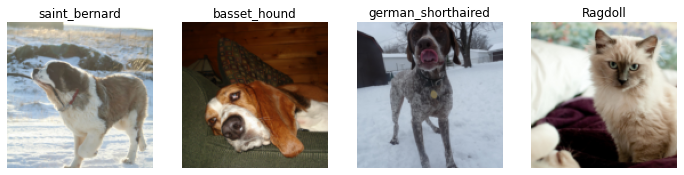

In [47]:
dls.valid.show_batch(max_n=4, nrows=1)

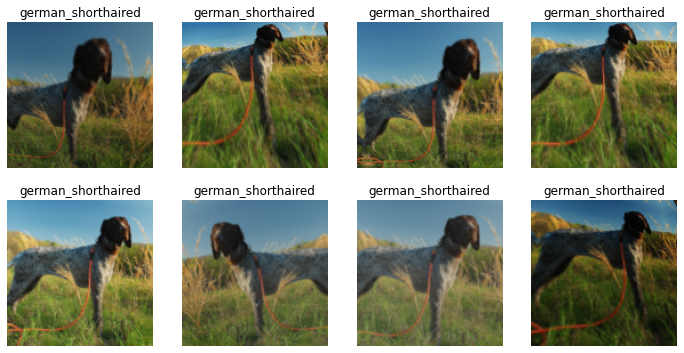

In [48]:
cat_dog = cat_dog.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cat_dog.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [49]:
cat_dog = cat_dog.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cat_dog.dataloaders(path)

In [52]:
learn = cnn_learner(dls, resnet18, metrics=error_rate, num_workers=0)
learn.fine_tune(4)

RuntimeError: DataLoader worker (pid(s) 49258, 49260, 49263, 49265) exited unexpectedly

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)